In [ ]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/siyu/Suicide_Detection_final1.csv')
data

,Unnamed: 0,text,class,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,51%,68%,27%,35%,67%
1,3,Am I weird I don't get affected by compliments...,non-suicide,98%,0%,1%,17%,100%
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,89%,7%,1%,11%,56%
3,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,97%,12%,22%,26%,93%
4,19,I took the rest of my sleeping pills and my pa...,suicide,98%,69%,0%,63%,90%
...,...,...,...,...,...,...,...,...
995,2521,I'm a 17 year old senior and I sometimes feel ...,suicide,75%,37%,26%,36%,85%
996,2530,I just want to go to sleep and not wake upI ha...,suicide,76%,21%,0%,17%,97%
997,2534,Help. I'm so lost.I feel so helpless despite t...,suicide,88%,25%,18%,15%,99%
998,2535,Anybody else get really scared when you get cl...,suicide,98%,41%,49%,54%,98%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Correlation Analysis & Feature Importance Analysis

In [ ]:
# Check the data type of each column
print(data.dtypes)


Unnamed: 0                 int64
text                      object
class                     object
Openness to Experience    object
Conscientiousness         object
Extraversion              object
Agreeableness             object
Neuroticism               object
dtype: object


<ipython-input-4-88998a6cb8d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})
<ipython-input-4-88998a6cb8d3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
<ipython-input-4-88998a6cb8d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

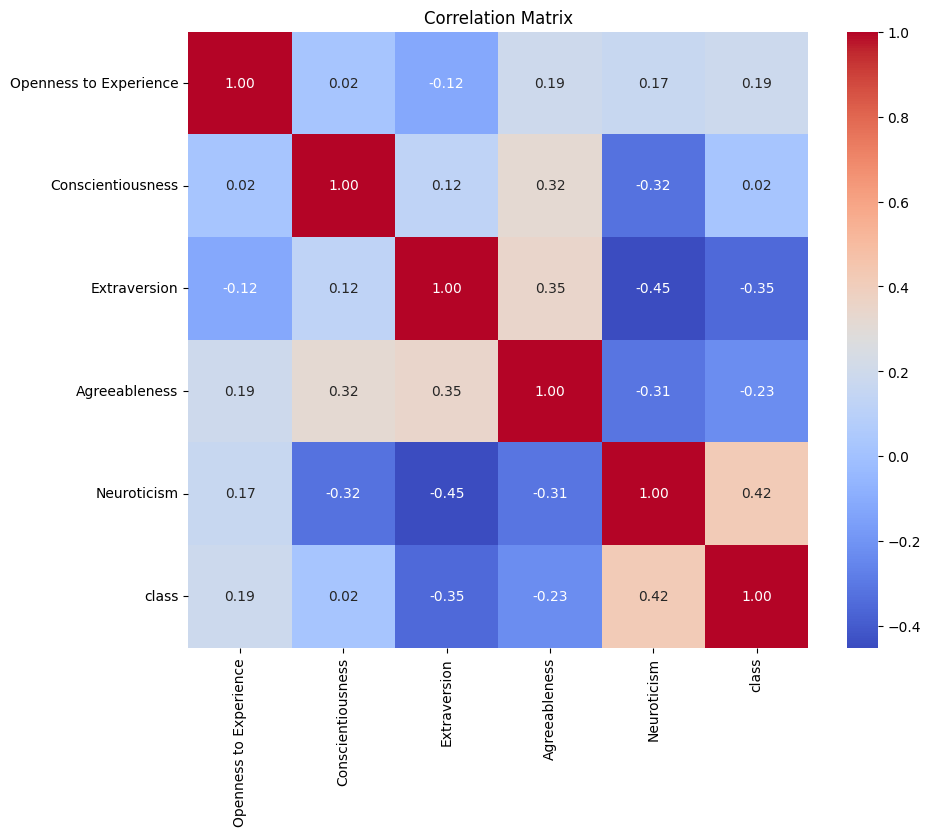

In [ ]:
# Keep the desired columns
data = data[['Openness to Experience', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism', 'class']]

# Encode the 'class' column as a numeric type
data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})

# Remove the percentage symbols and convert the data to floating numbers
data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
data['Conscientiousness'] = data['Conscientiousness'].str.rstrip('%').astype(float)
data['Extraversion'] = data['Extraversion'].str.rstrip('%').astype(float)
data['Agreeableness'] = data['Agreeableness'].str.rstrip('%').astype(float)
data['Neuroticism'] = data['Neuroticism'].str.rstrip('%').astype(float)

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


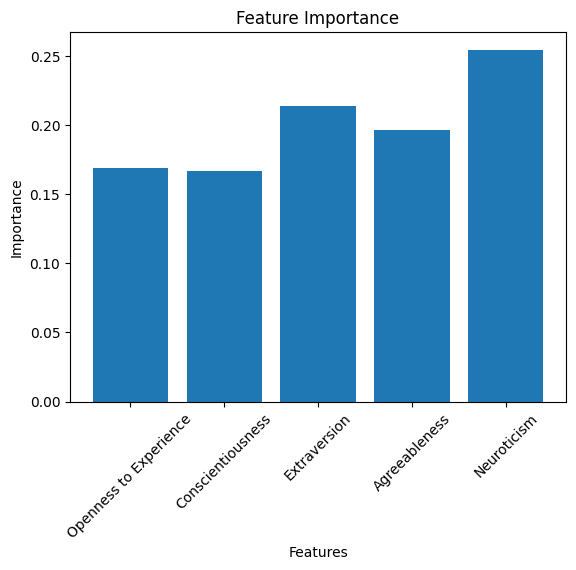

In [ ]:
# Split the features and labels
X = data[['Openness to Experience', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']]
y = data['class']

# Feature normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a random forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Obtain feature importance
feature_importances = rf_model.feature_importances_

# Visualize feature importance
import matplotlib.pyplot as plt

plt.bar(X.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()


#Feature Selection

Combining the above two analysis results, we can make the following decisions for feature selection:

1. The traits Neuroticism, Extraversion and Agreeableness are preserved. Based on both correlation analysis and featute importance analysis, they have a relatively strong positive/negative relationship with the target variable suicidal ideation. Retaining these features may improve the predictive power of the model.
3. Conscientiousness and Openness to Experience feature may be considered for deletion. In both analyses, these two featurea are less relevant and less important to the target variable. Removing it simplifies the model and avoids overfitting.

In [ ]:
# Select features
selected_features = ['Neuroticism', 'Extraversion', 'Agreeableness']
X = data[selected_features]
y = data['class']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelinhg

##1. XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('XGBoost Results:')
print(classification_report(y_test, y_pred_xgb, digits=4))

XGBoost Results:
              precision    recall  f1-score   support

           0     0.7241    0.6774    0.7000        93
           1     0.7345    0.7757    0.7545       107

    accuracy                         0.7300       200
   macro avg     0.7293    0.7266    0.7273       200
weighted avg     0.7297    0.7300    0.7292       200



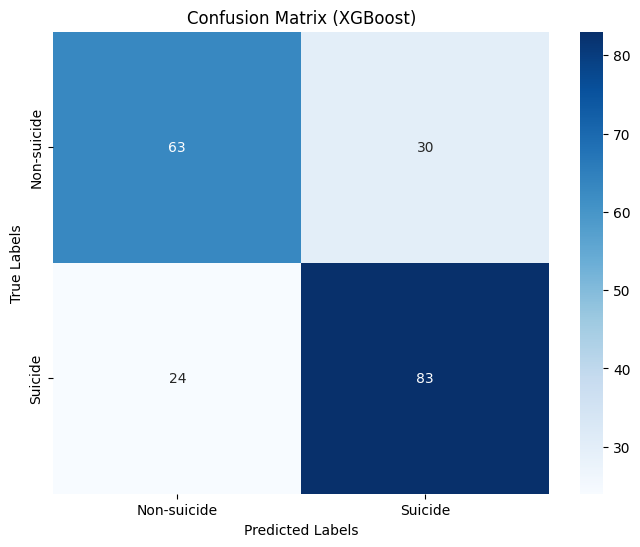

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

##2. Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('Random Forest Results:')
print(classification_report(y_test, y_pred_rf, digits=4))

Random Forest Results:
              precision    recall  f1-score   support

           0     0.7442    0.6882    0.7151        93
           1     0.7456    0.7944    0.7692       107

    accuracy                         0.7450       200
   macro avg     0.7449    0.7413    0.7422       200
weighted avg     0.7450    0.7450    0.7441       200



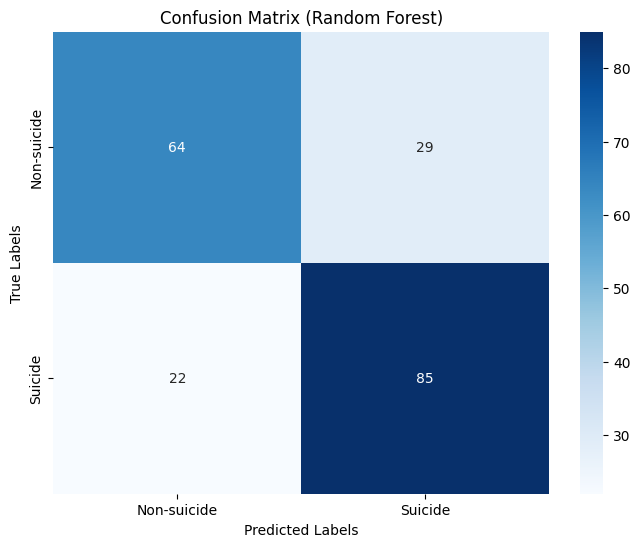

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

##3. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Logistic Regression Results:')
print(classification_report(y_test, y_pred_lr, digits=4))

Logistic Regression Results:
              precision    recall  f1-score   support

           0     0.7841    0.7419    0.7624        93
           1     0.7857    0.8224    0.8037       107

    accuracy                         0.7850       200
   macro avg     0.7849    0.7822    0.7830       200
weighted avg     0.7850    0.7850    0.7845       200



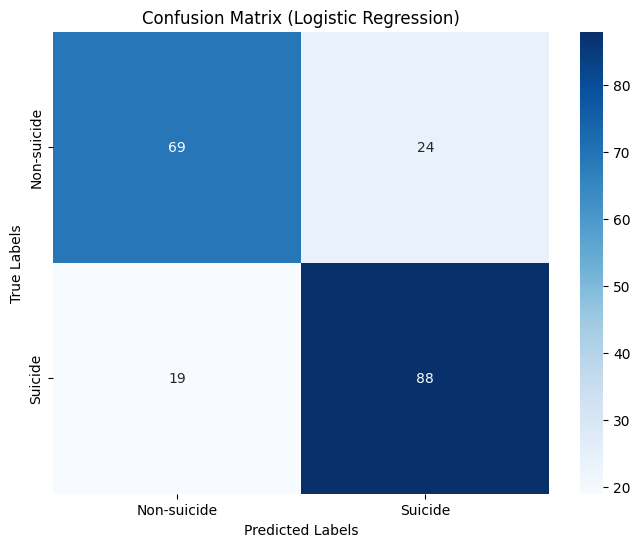

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

##4. SVM

In [ ]:
from sklearn.svm import SVC

# Support Vector Machine
svm = SVC(probability=True)
svm.fit(X_train.values, y_train)
y_pred_svm = svm.predict(X_test.values)
print('SVM Results:')
print(classification_report(y_test, y_pred_svm, digits=4))

SVM Results:
              precision    recall  f1-score   support

           0     0.7553    0.7634    0.7594        93
           1     0.7925    0.7850    0.7887       107

    accuracy                         0.7750       200
   macro avg     0.7739    0.7742    0.7740       200
weighted avg     0.7752    0.7750    0.7751       200



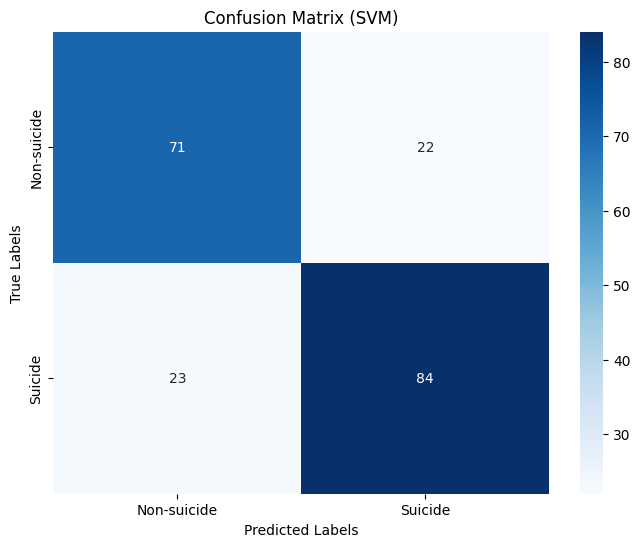

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SVM)')
plt.show()